# Photonics Transient

In this advanced demonstration, we simulate the non-linear transient response of a photonic circuit. We revisit the standard waveguide model but introduce Two-Photon Absorption (TPA). 

In linear optics, loss is constant ($\alpha$). In the non-linear regime, loss becomes intensity-dependent ($\alpha + \beta I$). This creates an Optical Limiting effect: as the optical power increases, the material absorbs more efficiently, effectively "clamping" the output power. This example demonstrates two critical capabilities of the solver:

Dynamic S-Matrices: Unlike the previous linear examples where the system matrix was constant, here the scattering parameters $S(t)$ are a function of the instantaneous state $|E(t)|^2$. The solver re-evaluates the component physics at every femtosecond time-step.

Complex Envelopes: Optical signals oscillate at hundreds of terahertz ($193\text{THz}$). To make simulation feasible, we simulate the complex slowly-varying envelope $A(t)$ rather than the raw field, using a Real-Imaginary Flattening strategy to map the complex state to the solver's real-valued requirements.

What to Expect: A high-power Gaussian pulse will be launched into the waveguide. In the linear regeime, the output is just a scaled, delayed version of the input, however with tpa_coeff > 0, pulse reshaping is observed. The peak of the Gaussian (high intensity) will be flattened or "squashed" due to the non-linear loss, while the tails (low intensity) pass through with standard linear attenuation.

In [1]:
import jax
import jax.numpy as jnp

from circulus.compiler import compile_netlist
from circulus.solvers.strategies import DenseSolver
import matplotlib.pyplot as plt
import diffrax
from circulus.components import Resistor
from circulus.photonic_components import OpticalSourcePulse
from circulus.solvers.transient import VectorizedTransientSolver
from circulus.base_component import component, source, Signals, States

KLUJAX_RS DEBUG MODE.


In [2]:
from circulus.s_transforms import s_to_y

@component(ports=("p1", "p2"))
def OpticalWaveguide(
    signals: Signals, 
    s: States, 
    length_um: float = 100.0,
    loss_dB_cm: float = 1.0,
    tpa_coeff: float = 0.0, # New Parameter: TPA Coefficient (1/W or similar)
    neff: float = 2.4,
    n_group: float = 4.0,
    center_wavelength_nm: float = 1310.0,
    wavelength_nm: float = 1310.0
):
    """
    Optical Waveguide with Linear Loss and Non-Linear Two-Photon Absorption (TPA).
    """
    # 1. Linear Phase & Dispersion
    d_lam = wavelength_nm - center_wavelength_nm
    slope = (neff - n_group) / center_wavelength_nm
    n_eff_disp = neff + slope * d_lam
    
    # Phase calculation (beta * L)
    phi = 2.0 * jnp.pi * n_eff_disp * (length_um / wavelength_nm) * 1000.0
    
    # 2. Linear Loss Calculation
    # Convert dB/cm to linear attenuation factor over the full length
    loss_val_dB = loss_dB_cm * (length_um / 10000.0)
    T_lin_mag = 10.0 ** (-loss_val_dB / 20.0) # Linear transmission amplitude

    # 3. Non-Linear TPA Calculation
    # Calculate instantaneous power at ports (|V|^2)
    # Note: We use the complex magnitude squared. 
    P_p1 = jnp.abs(signals.p1)**2
    P_p2 = jnp.abs(signals.p2)**2
    
    # Calculate Effective Length (L_eff) for TPA
    # This accounts for linear loss reducing power along the length
    # Alpha in 1/cm approx = loss_dB_cm * 0.23
    alpha_cm = loss_dB_cm * 0.23026 
    L_cm = length_um / 10000.0
    
    # Avoid division by zero if loss is 0
    L_eff = jnp.where(
        alpha_cm > 1e-9, 
        (1.0 - jnp.exp(-alpha_cm * L_cm)) / alpha_cm, 
        L_cm
    )
    
    # Calculate Power-Dependent Attenuation Factor
    # Transmission = 1 / (1 + beta * P * Leff)
    # We take sqrt() because we are operating on Voltage/Field amplitude, not Power.
    # TPA reduces transmission as power increases.
    tpa_factor_fwd = 1.0 / jnp.sqrt(1.0 + tpa_coeff * P_p1 * L_eff)
    tpa_factor_bwd = 1.0 / jnp.sqrt(1.0 + tpa_coeff * P_p2 * L_eff)

    # 4. S-Matrix Construction
    # Combine Linear Loss * TPA Loss * Phase
    # Forward (1->2) depends on P1
    T_fwd = T_lin_mag * tpa_factor_fwd * jnp.exp(-1j * phi)
    # Backward (2->1) depends on P2
    T_bwd = T_lin_mag * tpa_factor_bwd * jnp.exp(-1j * phi)
    
    S = jnp.array([
        [0.0,   T_bwd], 
        [T_fwd, 0.0]
    ], dtype=jnp.complex128)
    
    # 5. Output Calculation
    # Convert S to Y (Admittance) for the circuit solver
    Y = s_to_y(S)
    
    v_vec = jnp.array([signals.p1, signals.p2], dtype=jnp.complex128)
    i_vec = Y @ v_vec
    
    return {"p1": i_vec[0], "p2": i_vec[1]}, {}

--- DEMO: Photonic Transient (Flat Vector Fix) ---
1. Compiling...
2. Solving DC Operating Point...
   DC Converged. Norm: 1.92e+00
3. Running Transient Simulation...
   ✅ Simulation Successful


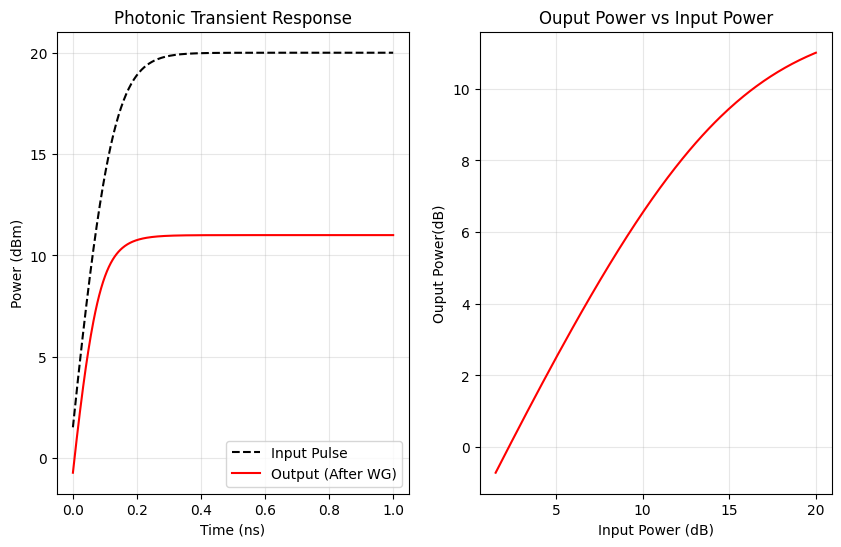

In [3]:
print("--- DEMO: Photonic Transient (Flat Vector Fix) ---")

jax.config.update ("jax_enable_x64", True)

models_map = {
    'waveguide': OpticalWaveguide,
    'source': OpticalSourcePulse,
    'resistor': Resistor,
    'ground': lambda: 0
}

net_dict = {
    "instances": {
        "GND": {"component": "ground"},
        "I1": {"component": "source", "settings": {"power": 100.0, "delay": 0.1e-9}},
        "WG1": {"component": "waveguide", "settings": {"length_um": 1000.0, "loss_dB_cm": 20.0, "tpa_coeff":5E-1}},
        "R1": {"component": "resistor", "settings": {"R": 1.0}}
    },
    "connections": {
        "GND,p1": ("I1,p2", "R1,p2"),
        "I1,p1": "WG1,p1",
        "WG1,p2": "R1,p1"
    }
}

print("1. Compiling...")
groups, sys_size, port_map = compile_netlist(net_dict, models_map)

linear_strat = DenseSolver.from_circuit(groups, sys_size, is_complex=True)

print("2. Solving DC Operating Point...")

y_guess_flat = jnp.zeros(sys_size * 2, dtype=jnp.float64)
y_op_flat = linear_strat.solve_dc(groups, y_guess_flat)

print(f"   DC Converged. Norm: {jnp.linalg.norm(y_op_flat):.2e}")

solver = VectorizedTransientSolver(linear_solver=linear_strat)
term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))

t_max = 1.0e-9
saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_max, 500))

print("3. Running Transient Simulation...")
sol = diffrax.diffeqsolve(
    terms=term,
    solver=solver,
    t0=0.0,
    t1=t_max,
    dt0=1e-13,
    y0=y_op_flat,
    args=(groups, sys_size),
    saveat=saveat,
    max_steps=100000,
    throw=False,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6)
)

if sol.result == diffrax.RESULTS.successful:
    print("   ✅ Simulation Successful")
    
    ts = sol.ts * 1e9
    
    ys_flat = sol.ys
    ys_complex = ys_flat[:, :sys_size] + 1j * ys_flat[:, sys_size:]
    
    node_in_idx  = port_map["I1,p1"]
    node_out_idx = port_map["R1,p1"]

    v_in = ys_complex[:, node_in_idx]
    v_out = ys_complex[:, node_out_idx]
    
    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10, 6))
    axes = axes.ravel()
    
    axes[0].plot(ts, 20*jnp.log10(jnp.abs(v_in)), 'k--', label='Input Pulse')
    axes[0].plot(ts, 20*jnp.log10(jnp.abs(v_out)), 'r-', label='Output (After WG)')
    
    axes[0].set_title("Photonic Transient Response")
    axes[0].set_xlabel("Time (ns)")
    axes[0].set_ylabel("Power (dBm)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_title("Ouput Power vs Input Power")
    axes[1].set_xlabel("Input Power (dB)")
    axes[1].set_ylabel("Ouput Power(dB)")
    axes[1].plot(20*jnp.log10(jnp.abs(v_in)), (20*jnp.log10(jnp.abs(v_out))), 'r-', label='Loss')
    axes[1].grid(True, alpha=0.3)
else:
    print(f"❌ Simulation Failed: {sol.result}")